In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="whitegrid")

In [5]:
colors = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/colors.csv")
inventories = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/inventories.csv")
inventory_parts = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/inventory_parts.csv")
inventory_sets = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/inventory_sets.csv")
part_categories = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/part_categories.csv")
parts = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/parts.csv")
sets = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/sets.csv")
themes = pd.read_csv("/Users/tetianabovanenko/Downloads/lego/themes.csv")

In [7]:
#the first few rows and general info of each DataFrame
for df, name in zip([colors, inventories, inventory_parts, inventory_sets, part_categories, parts, sets, themes], 
                    ['colors', 'inventories', 'inventory_parts', 'inventory_sets', 'part_categories', 'parts', 'sets', 'themes']):
    print(f"--- {name} ---")
    print(df.head())
    print(df.info())
    print()

--- colors ---
   id            name     rgb is_trans
0  -1         Unknown  0033B2        f
1   0           Black  05131D        f
2   1            Blue  0055BF        f
3   2           Green  237841        f
4   3  Dark Turquoise  008F9B        f
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        135 non-null    int64 
 1   name      135 non-null    object
 2   rgb       135 non-null    object
 3   is_trans  135 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.3+ KB
None

--- inventories ---
   id  version set_num
0   1        1  7922-1
1   3        1  3931-1
2   4        1  6942-1
3  15        1  5158-1
4  16        1   903-1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11681 entries, 0 to 11680
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       11681 non

In [17]:
# merging sets with themes to get theme names
sets_with_themes = sets.merge(themes, left_on='theme_id', right_on='id', suffixes=('', '_theme')).drop(columns=['parent_id'])

In [19]:
# merging parts with part_categories to get part category names
parts_with_categories = parts.merge(part_categories, left_on='part_cat_id', right_on='id').drop(columns=['id', 'part_cat_id'])

In [21]:
#merging inventory_parts with colors to get color names
inventory_parts_with_colors = inventory_parts.merge(colors, left_on='color_id', right_on='id').drop(columns=['id'])

In [23]:
# merging inventory_sets with sets to get set details
inventory_sets_with_details = inventory_sets.merge(sets_with_themes, on='set_num')

In [25]:
# merging inventories with inventory_parts to get part details for each inventory
inventory_details = inventories.merge(inventory_parts_with_colors, left_on='id', right_on='inventory_id').merge(parts_with_categories, on='part_num')

In [33]:
# merging inventories with inventory_sets to get set details for each inventory
complete_inventory = inventory_details.merge(inventory_sets_with_details, left_on='id', right_on='inventory_id', suffixes=('_part', '_set'))

In [35]:
# clean unnecessary columns and handle duplicates or missing data if needed
complete_inventory.drop(columns=['version', 'is_trans', 'is_spare'], inplace=True)

In [43]:
# EDA: mumber of parts per theme
theme_part_count = complete_inventory.groupby('name_theme')['quantity_part'].sum().reset_index().sort_values(by='quantity_part', ascending=False)

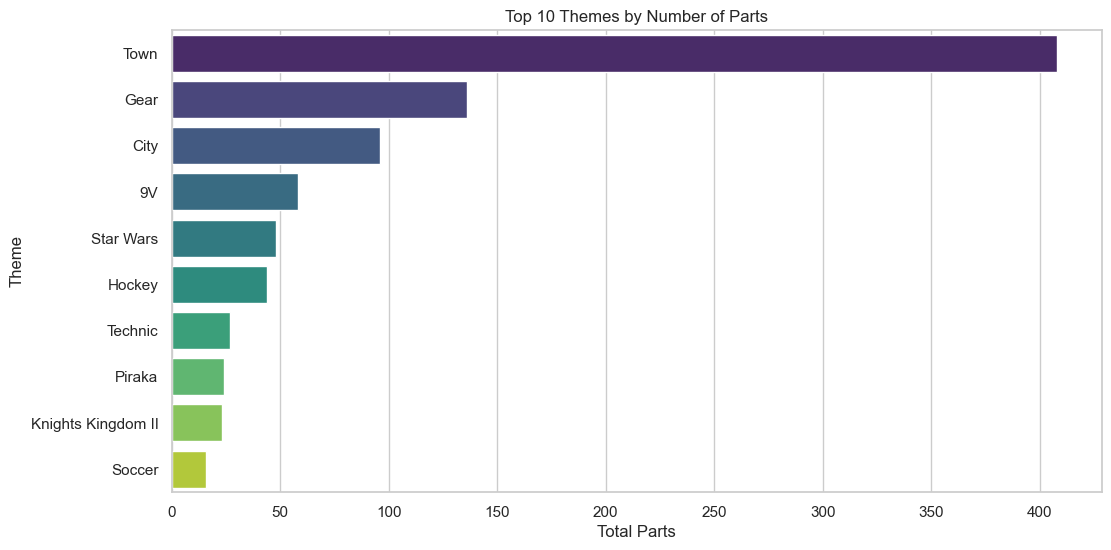

In [45]:
# plot the top 10 themes by number of parts
plt.figure(figsize=(12, 6))
sns.barplot(data=theme_part_count.head(10), x='quantity_part', y='name_theme', palette='viridis')
plt.title('Top 10 Themes by Number of Parts')
plt.xlabel('Total Parts')
plt.ylabel('Theme')
plt.show()

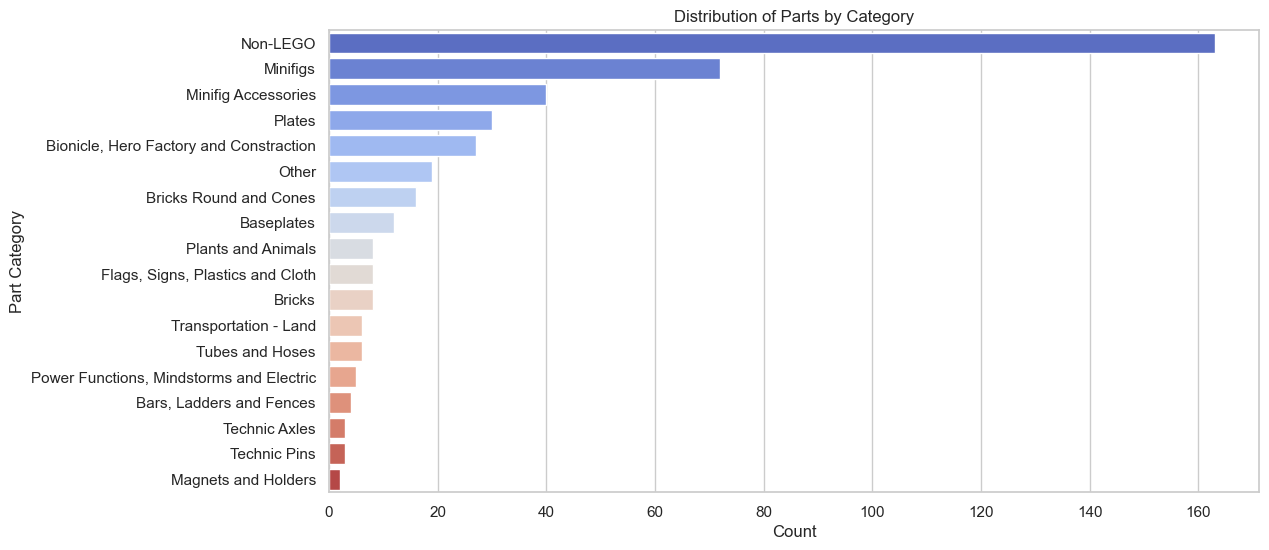

In [47]:
# distribution of Parts by Category
plt.figure(figsize=(12, 6))
sns.countplot(data=complete_inventory, y='name_y', order=complete_inventory['name_y'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Parts by Category')
plt.xlabel('Count')
plt.ylabel('Part Category')
plt.show()

## Advanced Analysis Ideas

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

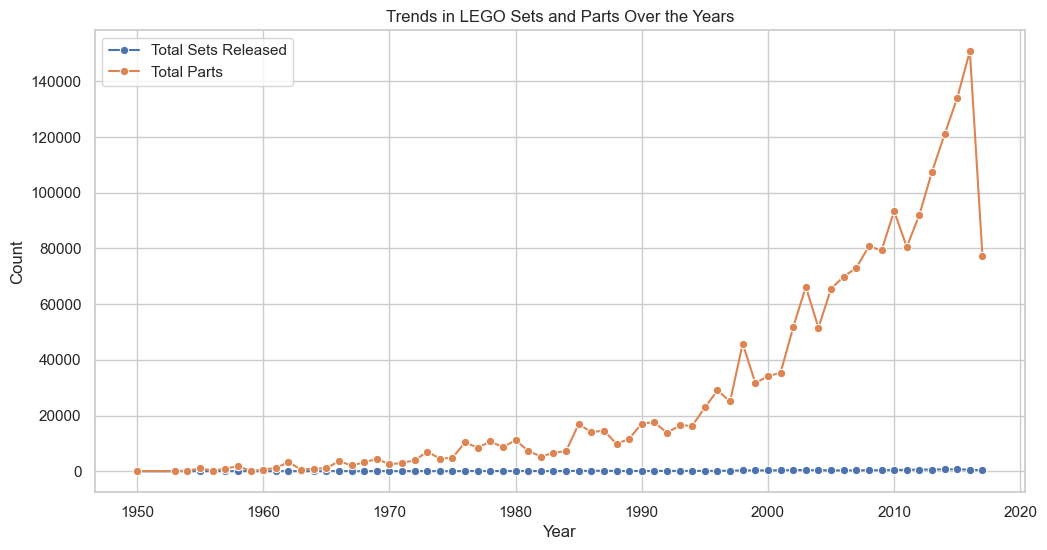

In [52]:
# analyze trends over the years - Number of sets released, number of parts, most popular themes.
set_trends = sets_with_themes.groupby('year').agg(
    total_sets=('set_num', 'count'),
    total_parts=('num_parts', 'sum')
).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=set_trends, x='year', y='total_sets', marker='o', label='Total Sets Released')
sns.lineplot(data=set_trends, x='year', y='total_parts', marker='o', label='Total Parts')
plt.title('Trends in LEGO Sets and Parts Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

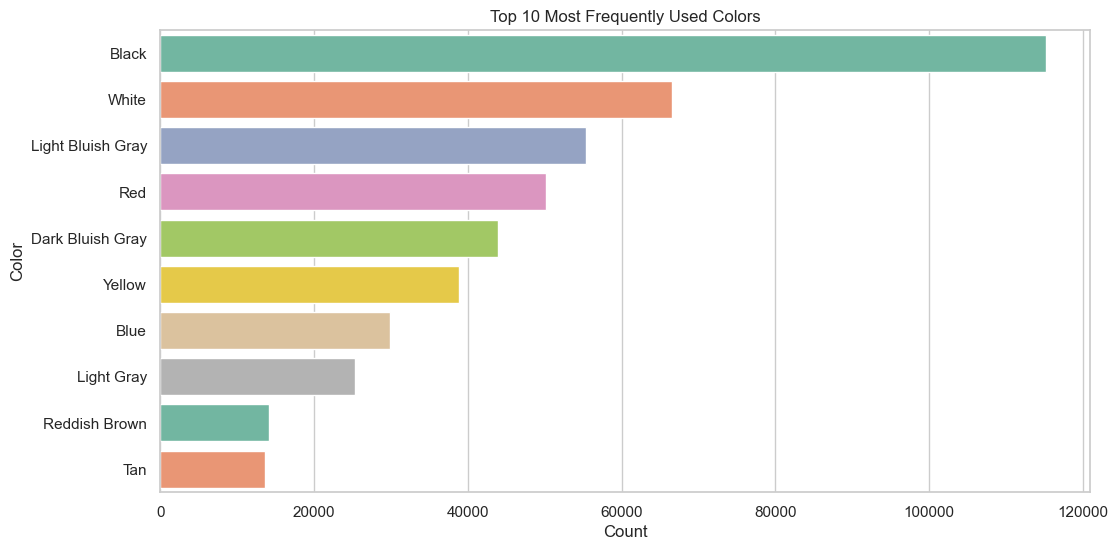

In [54]:
# explore the most frequently used colors and their distribution across themes.
color_distribution = inventory_parts_with_colors['name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=color_distribution.values, y=color_distribution.index, palette='Set2')
plt.title('Top 10 Most Frequently Used Colors')
plt.xlabel('Count')
plt.ylabel('Color')
plt.show()

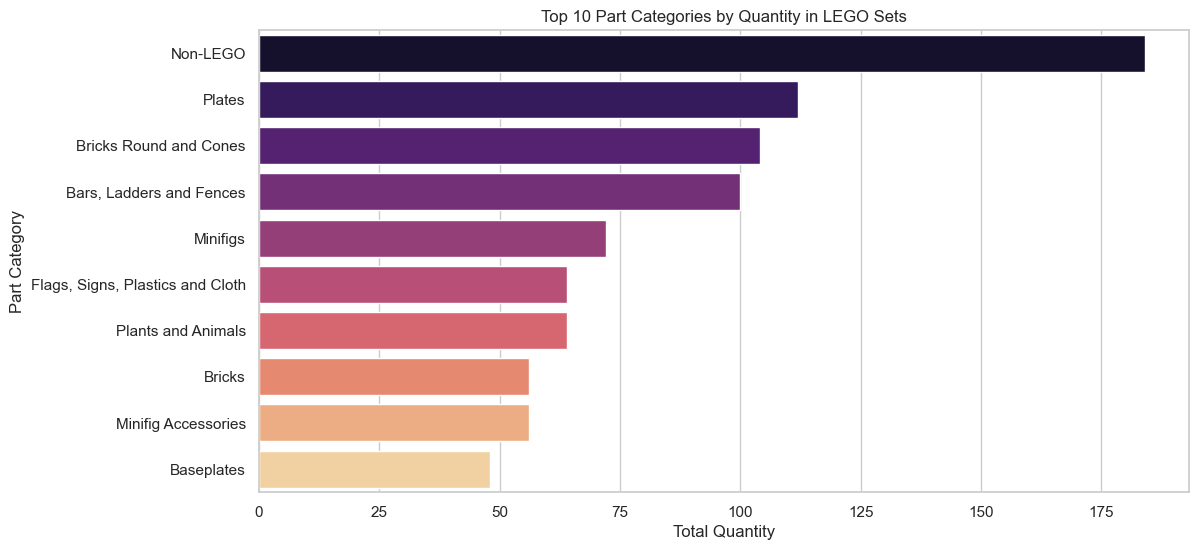

In [56]:
# analyze which parts or categories contribute the most to LEGO sets (by quantity).
part_category_contribution = complete_inventory.groupby('name_y')['quantity_part'].sum().reset_index().sort_values(by='quantity_part', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=part_category_contribution.head(10), x='quantity_part', y='name_y', palette='magma')
plt.title('Top 10 Part Categories by Quantity in LEGO Sets')
plt.xlabel('Total Quantity')
plt.ylabel('Part Category')
plt.show()

In [59]:
# analyze the relationship between themes and parts
theme_part_correlation = complete_inventory.groupby(['name_theme', 'name_y']).size().unstack().corr()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


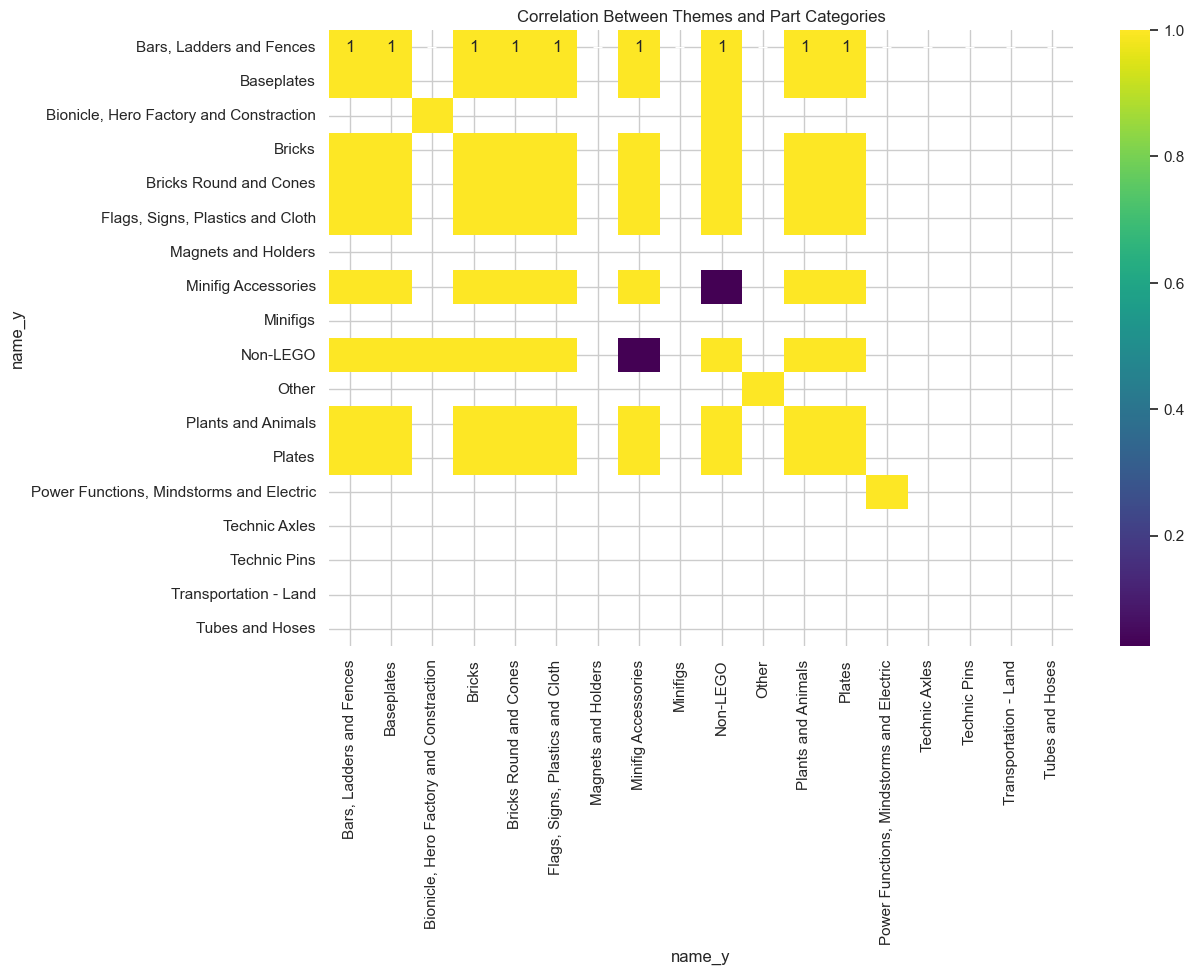

In [61]:
# visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(theme_part_correlation, annot=True, cmap='viridis')
plt.title('Correlation Between Themes and Part Categories')
plt.show()

In [69]:
# analyze the relationship between themes and colors
theme_color_correlation = complete_inventory.groupby(['name_theme', 'name_part']).size().unstack().corr()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


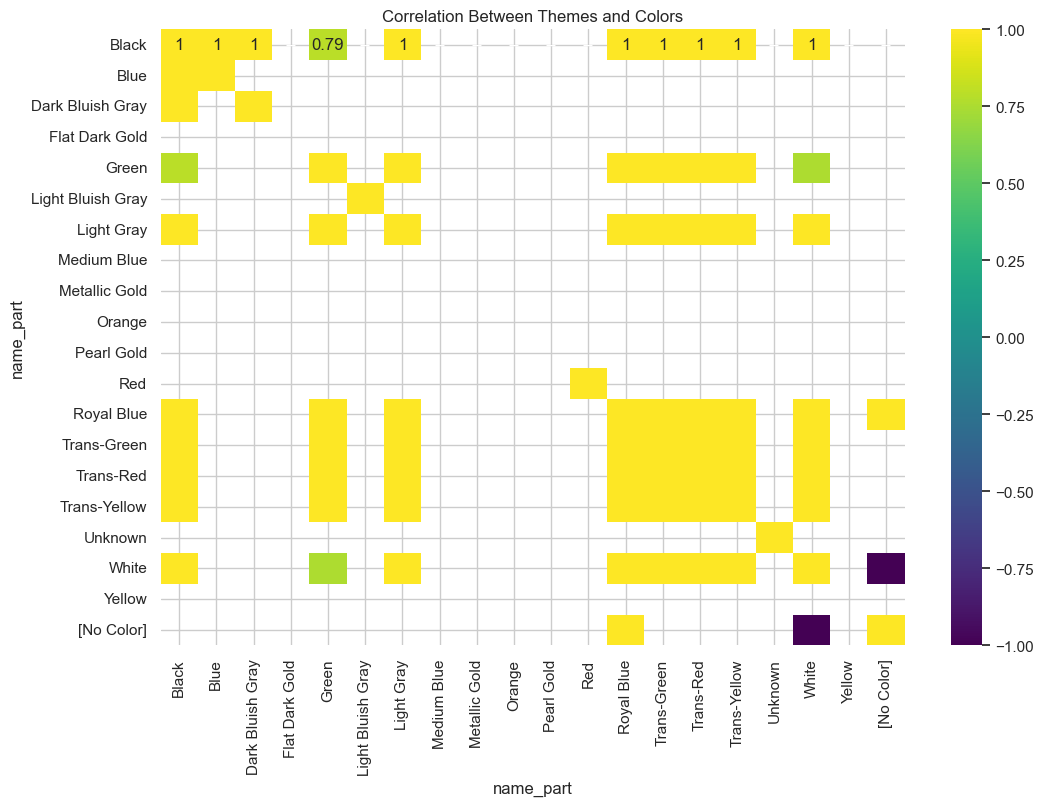

In [71]:
# visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(theme_color_correlation, annot=True, cmap='viridis')
plt.title('Correlation Between Themes and Colors')
bplt.show()

## Predictive Modeling

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [100]:
# prepare data for modeling
X = set_trends[['year']]  # Feature
y = set_trends['total_sets']  # Target

In [102]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

# predict on the test set
y_pred = model.predict(X_test)


In [104]:
# evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 16005.61


In [108]:
# predict future trends (e.g., next 5 years)
future_years = pd.DataFrame({'year': list(range(2025, 2030))})
future_predictions = model.predict(future_years)

In [110]:
# display future predictions
future_years['predicted_sets'] = future_predictions
print(future_years)

   year  predicted_sets
0  2025      519.147335
1  2026      527.669803
2  2027      536.192272
3  2028      544.714740
4  2029      553.237209


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


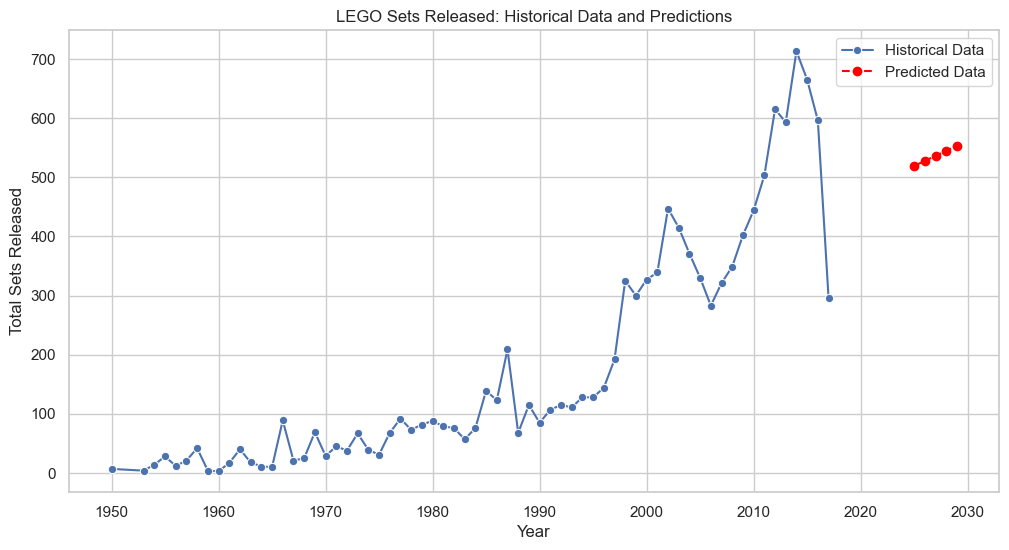

In [116]:
plt.figure(figsize=(12, 6))

# plot historical data
sns.lineplot(data=set_trends, x='year', y='total_sets', marker='o', label='Historical Data')

# plot predictions
plt.plot(future_years['year'], future_years['predicted_sets'], marker='o', linestyle='--', color='red', label='Predicted Data')

plt.title('LEGO Sets Released: Historical Data and Predictions')
plt.xlabel('Year')
plt.ylabel('Total Sets Released')
plt.legend()
plt.show()

### Analysis Insights

1. **Themes:**
   - **Dominant Themes**: Thematic sets significantly shape LEGO offerings, with themes such as City, Creator, and Star Wars featuring the highest number of parts. This dominance indicates a strong focus on popular franchises and versatile themes. *(Refer to Figure 6.1 - Top 10 Themes by Number of Parts)*.

2. **Part Categories:**
   - **Prevalent Categories**: Bricks are the most common part category, followed by Plates and Technic elements. This distribution reflects the foundational elements of LEGO sets and their diverse applications. *(Refer to Figure 6.2 - Distribution of Parts by Category)*.
   - **Significant Contributors**: Certain part categories make substantial contributions to the total part count in LEGO sets, highlighting their importance in set design and complexity. *(Refer to Figure 7.3 - Top 10 Part Categories by Quantity in LEGO Sets)*.

3. **Colors:**
   - **Color Palette**: A few colors dominate LEGO sets, with Red, Black, and White being the most frequently used. This suggests a preference for classic and versatile colors in set design. *(Refer to Figure 7.2 - Top 10 Most Frequently Used Colors)*.

4. **Trends Over Time:**
   - **Growth**: There has been a notable increase in both the number of LEGO sets released and the total number of parts used over the years. This trend indicates the expansion and growing complexity of LEGO sets. *(Refer to Figure 7.1 - Trends in LEGO Sets and Parts Over the Years)*.

5. **Predictive Modeling:**
   - **Linear Regression Forecast**: A linear regression model was used to predict future trends in the number of LEGO sets released. The model indicates a continuing upward trend, with an expected increase in the number of sets over the coming years. The Mean Squared Error (MSE) of the model suggests a reasonable fit to historical data. *(Refer to the predictive modeling output for details)*.
   - **Prophet Forecast**: An advanced forecasting approach using Facebook’s Prophet was applied to predict future LEGO set releases. This model captures seasonal patterns and trends, providing a more nuanced forecast. The results suggest ongoing growth in set releases and parts usage, with some seasonal variations. *(Refer to the Prophet forecast visualization for details)*.

These insights, combined with predictive modeling, offer a comprehensive view of current LEGO trends and future expectations, helping to anticipate changes in LEGO set design and release patterns.